#Machine Learning project 

Group members: Annela Pajumets, Kadi Kilgi, Kadi-Liis Kuum, Laura Anna Tammesoo

December 2021

# Introduction


The aim of this Machine Learning course project is to take part of a Kaggle competiton - House Prices. [1] The goal is to find a best regression model which can describe the sale prices of houses. The goodness of a model is evaluated by the Root mean squared error (RMSE).



# 1. Reading in the data 

In [2]:
import numpy as np 
import pandas as pd
 
train =  pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#importing needed packages 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Lasso, Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# 2. Description of the data

The dataset contains information about houses in Ames, Iowa in the USA. Parameters include data about roof, garage, utilities, location, etc.

In [4]:
print(train.shape)
print(test.shape)

(1460, 81)
(1459, 80)


Train set has 1460 rows and 81 variables, including "Id" and "SalePrice", the last is our target variable. Test set has 1459 observations.

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The dataset has 79 parameters for predicting "SalePrice", of which 47 are categorical variables and 32 are numerical. Categorical variables describe for example the style and material of roof, the foundation and exterior of house, utilities, location, etc. Numerical variables are for example the size of lot, basement, first and second floor (in square feet), etc. There is also data about the month and year of the sale and the type of sale.

We want to predict variable "SalePrice" which shows the price of house in US dollars.

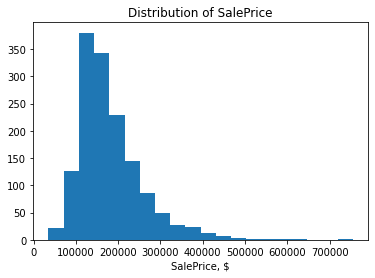

In [6]:
plt.hist(train['SalePrice'], bins = 20)
plt.xlabel('SalePrice, $')
plt.title('Distribution of SalePrice')
plt.show()

In [7]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We see that "SalePrice" is skewed to the left with 75% of values lying between 34 900\$ and 214 000\$. The biggest "SalePrice" is 755 000$.

In [8]:
correl = train.corr()
correl.sort_values(["SalePrice"],ascending = False, inplace = True)
print(correl.SalePrice)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

We see that "SalePrice" has the biggest correlation with "OverallQual" which shows the overall rate of the material and finish of the house (a categorical variable) and "GrLivArea" which shows the living area in square feet (a numerical variable).

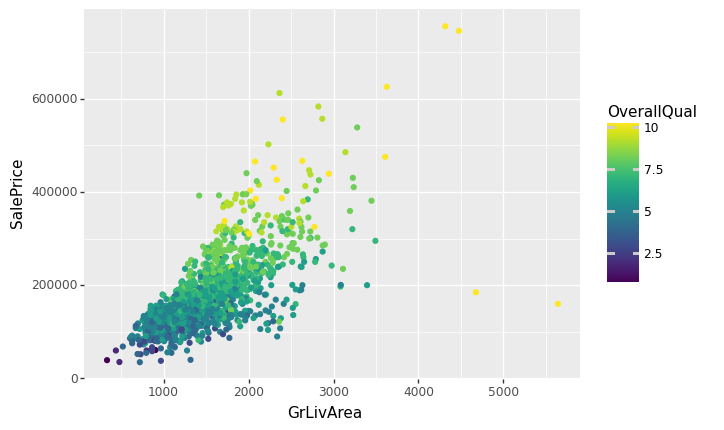

In [9]:
fig = (
    ggplot(data = train,
          mapping = aes(x = 'GrLivArea', y = 'SalePrice', color = 'OverallQual')) +
#    geom_point(position = "jitter") 
    geom_point()
).draw()

Heatmap of correlation between some of the numerical variables in the data set. 

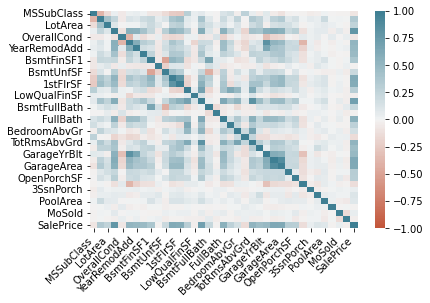

In [10]:
train_0 = train.drop('Id', axis=1)

ax = sns.heatmap(
    train_0.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200) #,
    #square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45 ,
    horizontalalignment='right'
);

# 3.Transform train and test before training (Feature engineering)

The data contains a lot of categorical variables. We will convert categorical variables into **dummy variables** (binary variables with values 0 and 1). 

One categorical variable is made into respective number of dummy variables as there are levels in the categorical variable. Each level gets a value of 0 or 1 depending on if the observation had that category present.  

We will make dummy variables together with test set to ensure that all the levels of the categorical variables used for training are also in the test set as test set may not contain some levels of all variables. [2]

In [11]:
X=train.drop(['SalePrice'],axis=1)
X['train']=1
test['train']=0

train_test=pd.concat([X,test])

Our dataset contains a lot of NaN (missing) values, but based on the data description we know that these missing values actually have a meaning. In general, a missing value for categorical features means that the house does not have this object or feature. For example, in case of the variable "BsmtQual" which describes the quality of the basement (Excellent, Good, etc), the missing value means that there is no basement. Therefore, we decided to recode this kind of the missing values in the dataset. 

Secondly, in terms of the categorical variables "Exterior1st", "Exterior2nd" and "SaleType", data description does not contain any information what the missing values mean. However, it is not possible that the response options of the categorical variable contain all the possible values/responses and therefore often "Other" answer option is used. Thus, we decided to recode such missing values to value "Other". Fortunately, there are not many such missing values. 

Also some numerical variables have missing values in our dataset. Most of them are recoded to 0 as for example there are usually no basement in the houses where the feature describing the basement size is NaN. Thus, it seemes logical to recode such missing values to 0. 

Finally, we decided to remove features "Id" and "GarageYrBlt" from the data. "Id" is removed because it is unique for every house (observation) and "GarageYrBlt" contains missing values which could not be substituted with some other value.

We also introduce new binary variables "1st_Quarter", "2nd_Quarter","3rd_Quarter", "4th_Quarter" which show whether the sale of the house was made in that quarter. These variables will be useful if in the quarters the house sale prices were different.

In [12]:
# Replacing Nan values

# Categorical variables
train_test.Alley = train_test.Alley.replace(np.nan, 'No_alley')
train_test.BsmtQual = train_test.BsmtQual.replace(np.nan, 'No_basement')
train_test.BsmtCond = train_test.BsmtCond.replace(np.nan, 'No_basement')
train_test.BsmtExposure = train_test.BsmtExposure.replace(np.nan, 'No_basement')
train_test.BsmtFinType1 = train_test.BsmtFinType1.replace(np.nan, 'No_basement')
train_test.BsmtFinType2 = train_test.BsmtFinType2.replace(np.nan, 'No_basement')
train_test.FireplaceQu = train_test.FireplaceQu.replace(np.nan, 'No_fireplace')
train_test.GarageType = train_test.GarageType.replace(np.nan, 'No_garage')
train_test.GarageFinish = train_test.GarageFinish.replace(np.nan, 'No_garage')
train_test.GarageQual = train_test.GarageQual.replace(np.nan, 'No_garage')
train_test.GarageCond = train_test.GarageCond.replace(np.nan, 'No_garage')
train_test.PoolQC = train_test.PoolQC.replace(np.nan, 'No_pool')
train_test.Fence = train_test.Fence.replace(np.nan, 'No_fence')
train_test.MiscFeature = train_test.MiscFeature.replace(np.nan, 'None')

# Only missing values in test set (categorical and numerical variables)
train_test.Exterior1st = train_test.Exterior1st.replace(np.nan, 'Other')
train_test.Exterior2nd = train_test.Exterior2nd.replace(np.nan, 'Other')
train_test.SaleType = train_test.SaleType.replace(np.nan, 'Oth') #Other category in dataset
train_test.BsmtFinSF1 = train_test.BsmtFinSF1.replace(np.nan, 0)
train_test.BsmtFinSF2 = train_test.BsmtFinSF2.replace(np.nan, 0)
train_test.BsmtUnfSF = train_test.BsmtUnfSF.replace(np.nan, 0)
train_test.TotalBsmtSF = train_test.TotalBsmtSF.replace(np.nan, 0)
train_test.BsmtFullBath = train_test.BsmtFullBath.replace(np.nan, 0)
train_test.BsmtHalfBath = train_test.BsmtHalfBath.replace(np.nan, 0)

# Numeric variables
train_test.MasVnrArea = train_test.MasVnrArea.replace(np.nan,0)
train_test.LotFrontage = train_test.LotFrontage.replace(np.nan,0)

# Dropping the variable 'GarageYrBlt' and 'Id'
train_test = train_test.drop(['GarageYrBlt'], axis = 1)
train_test = train_test.drop(['Id'], axis = 1)

In [13]:
train_test=pd.get_dummies(train_test)

In [14]:
train_df=train_test[train_test['train']==1]
test_df=train_test[train_test['train']==0]
train_df=train_df.drop(['train'],axis=1)
test_df=test_df.drop(['train'],axis=1)

In [15]:
train_df2 = pd.concat([train_df,train['SalePrice']], axis=1)
#drop NA values from the data
print(f'Old size: {len(train_df2)}')
train_df2 = train_df2.dropna(how = 'any', axis = 'rows')
print(f'New size: {len(train_df2)}')

train_df2['1st_quarter']=np.where( (train_df2['MoSold']==1) | (train_df2['MoSold']==2) | (train_df2['MoSold']==3) ,1,0)
train_df2['2nd_quarter']=np.where( (train_df2['MoSold']==4) | (train_df2['MoSold']==5) | (train_df2['MoSold']==6) ,1,0)
train_df2['3rd_quarter']=np.where( (train_df2['MoSold']==7) | (train_df2['MoSold']==8) | (train_df2['MoSold']==9) ,1,0)
train_df2['4th_quarter']=np.where( (train_df2['MoSold']==10) | (train_df2['MoSold']==11) | (train_df2['MoSold']==12) ,1,0)
train_df2 = train_df2.drop(['MoSold'], axis = 1)


Old size: 1460
New size: 1460


In [16]:
# Dropping rows with missing values (mostly missing values in test set, only one or two rows need to be removed)
train_df2 = train_df2.dropna(how = 'any', axis = 'rows')

In [17]:
train_df2.iloc[:,120:150].describe()

,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.195890,0.004795,0.001370,0.000685,0.982192,0.000685,0.000685,0.000685,0.007534,0.003425,0.004110,0.013699,0.000685,0.001370,0.034247,0.000685,0.041781,0.152055,0.000685,0.150685,0.0,0.073973,0.001370,0.017123,0.352740,0.141096,0.017808,0.013699,0.002055,0.004795
std,0.397021,0.069100,0.036999,0.026171,0.132299,0.026171,0.026171,0.026171,0.086502,0.058440,0.063996,0.116277,0.026171,0.036999,0.181924,0.026171,0.200157,0.359197,0.026171,0.357864,0.0,0.261816,0.036999,0.129775,0.477986,0.348240,0.132299,0.116277,0.045299,0.069100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Dummy variable "Exterior1st_Other"
isn not present in the train set, thus dropping this from the train set. 

In [18]:
train_df2[['Exterior1st_Other']].describe()

,Exterior1st_Other
count,1460.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [19]:
train_df2 = train_df2.drop(['Exterior1st_Other'], axis = 1)

Make the same data modification to the test set, so it would be ready for making sumbissions to Kaggle.

In [20]:
test_df = test_df.drop(['Exterior1st_Other'], axis = 1)

In [21]:
test_df['1st_quarter']=np.where( (test_df['MoSold']==1) | (test_df['MoSold']==2) | (test_df['MoSold']==3) ,1,0)
test_df['2nd_quarter']=np.where( (test_df['MoSold']==4) | (test_df['MoSold']==5) | (test_df['MoSold']==6) ,1,0)
test_df['3rd_quarter']=np.where( (test_df['MoSold']==7) | (test_df['MoSold']==8) | (test_df['MoSold']==9) ,1,0)
test_df['4th_quarter']=np.where( (test_df['MoSold']==10) | (test_df['MoSold']==11) | (test_df['MoSold']==12) ,1,0)
test_df = test_df.drop(['MoSold'], axis = 1)

In [22]:
test_df.fillna(0, inplace = True) #Replace test set NA-values with 0 as we have only numerical variables in final train set.

In [23]:
train_df2.shape

(1460, 305)

In [24]:
test_df.shape

(1459, 304)

# 4. Finding the best model for SalePrice

Now that the data preparation is done, we will try out different models. Our aim is to find the best model by RMSE. Also, we submit best models to Kaggle and get the score of root mean squared logarithmic error (RMSLE).

The equation for the RMSLE is the following

$RMSLE = \sqrt{\frac1n\sum_{i=1}^n (\log(\hat{y}_i+1)-\log(y_i+1))^2} $, 

where $n$ is the total number of observations in the data, $\hat{y}_i$ is the predicited value and $y_i$ is the actual value of observation $i$.

To evaluate the models we will use validation set.
We split train set from Kaggle to train (80%) and validation set (20%) and calculate models performances on validation set.
In addition we will use cross-validation to get the mean RMSE estimates of models and choose parameters of models (for example lasso regression's penalty value).

We are going to look at: 
1. Regression models - Vanilla, Lasso, Ridge
2. Decision Trees and Random Forests
3. Ensemble models
4. XGBoost, Gradient and Adaptive Boosting, Bagging 
5. Performing Principal Component Analysis for dimensionality reduction.

In [25]:
y_all=train_df2['SalePrice']
X_all=train_df2.drop(['SalePrice'],axis=1)
train_X, val_X, train_y, val_y = train_test_split(X_all, y_all,random_state=111, test_size = 0.20)

# 5. Regression models

Firstly, we will see how simple linear regression, Lasso and Ridge regressions perform. Later we will use them in ensemble models as well.

## 5.1 Linear Regression

In [ ]:
model_lr = LinearRegression()
model_lr.fit(train_X, train_y)
val_predictions_lr = model_lr.predict(val_X)

In [ ]:
mean_squared_error(val_y, val_predictions_lr , squared=False) #RMSE value

31567.76892309507

In Kaggle competition the score is computed with root mean squared logarithmic error.

In [ ]:
 mean_squared_log_error(val_y, val_predictions_lr, squared=False) #RMSLE value

0.1963467170465598

## 5.2 Linear regression with cross-validation

To get the implication how the simple linear regression works, we will train the model with cross-validation and get the mean RMSE on folds.

In [ ]:
model_lr = LinearRegression()

n_folds = 4 # we choose 4 folds
fold_RMSEs = np.zeros(n_folds)

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

# initialise splitting mechanism
folds = KFold(n_splits=n_folds, shuffle=True, random_state=111) # shuffle=True, random_state=111 

# here actual splitting is done
folds.get_n_splits(X, y)

fold_indx = 1

# folds.split is an iterator that loops over different folds
# returning a tuple with train and val indeces
for train_index, val_index in folds.split(X, y):
  #print(f"CV #{fold_indx}") # for computing 
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  # train the model
  model_lr.fit(X_train, y_train)

  val_predictions = model_lr.predict(X_val)
  fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions, squared = False)

  fold_indx += 1

print(f'Average validation RMSE is {np.mean(fold_RMSEs)}') 


Average validation RMSE is 41802.026353207766


Simple linear regression gives the mean RMSE value 41 802 with cross-validation, which is larger than on only using one validation set.

Next we will use entire train set for fitting. Then the result calculated on the predictions of the test set are submitted to Kaggle.

In [ ]:
model_lr = LinearRegression()
model_lr.fit(X_all, y_all)

LinearRegression()

Predictions on test set to submit to Kaggle.

In [ ]:
test_y_predictions_lr = model_lr.predict(test_df)

submission_lr = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_lr},
    columns = ['Id', 'SalePrice'])
submission_lr.to_csv('submission_lr.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_lr.csv -m "Linear regression submission"

100% 33.6k/33.6k [00:00<00:00, 93.9kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score 0.19424

## 5.3 Lasso Regression
To find the best parameter (lambda value) we perform the cross-validation algorithm.

In [ ]:
lambdas = [0.5, 1, 2, 3, 4, 5, 6, 8, 10, 15, 25, 50, 75, 100, 130, 140, 145, 150, 155, 160, 170, 500] # lambda values (we can try other lambda values too)

# let's collect RMSE values to find the best lambda
error = np.zeros(len(lambdas))

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

for i, lambda_ in enumerate(lambdas):
  #print(f'RMSE for lambda = {lambda_}...')

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into train_X, train_y and val_X, val_y depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the Lasso regression model with lambda_
    model = Lasso(alpha = lambda_, max_iter = 35000) # by default max_iter=1000
    #increase number of iteration because model has problem with convergence
    # however, it makes the algorithm much slower

    # fit the Lasso regression on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {lambda_} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

Average RMSE for 0.5 is 39233.68565118142
Average RMSE for 1 is 37287.1346064035
Average RMSE for 2 is 35785.423872332154
Average RMSE for 3 is 34979.87513751094
Average RMSE for 4 is 34010.95884129196
Average RMSE for 5 is 33839.37066625411
Average RMSE for 6 is 33673.890139838084
Average RMSE for 8 is 33370.98360625698
Average RMSE for 10 is 33167.73494181614
Average RMSE for 15 is 32796.945911117175
Average RMSE for 25 is 32201.261747745968
Average RMSE for 50 is 31633.13493261612
Average RMSE for 75 is 31310.52616742839
Average RMSE for 100 is 31160.29670969296
Average RMSE for 130 is 31062.856398069718
Average RMSE for 140 is 31042.86823462953
Average RMSE for 145 is 31034.61315914039
Average RMSE for 150 is 31029.128829671776
Average RMSE for 155 is 31029.49122046095
Average RMSE for 160 is 31032.687806831014
Average RMSE for 170 is 31051.601201308913
Average RMSE for 500 is 32670.618303137475


Text(0, 0.5, 'RMSE')

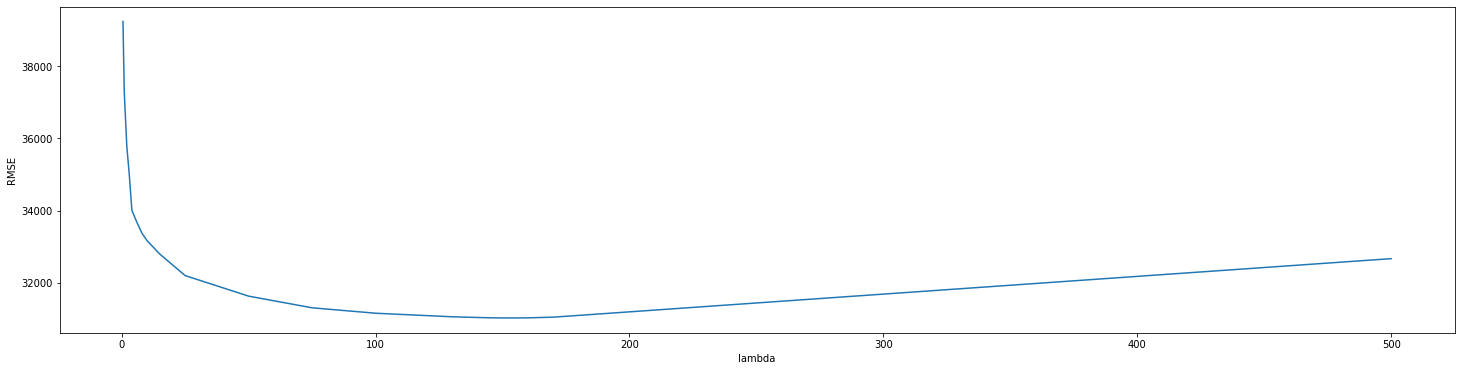

In [ ]:
# Figure
plt.figure(figsize=(25, 6)) 
plt.plot(lambdas, error)
plt.xlabel('lambda')
plt.ylabel('RMSE')

When executing Lasso regression, we had a problem with convergence. More precisely, Lasso regression did not converge with small lambda values (1-10) and therefore we had to change the max number of iterations. By default this parameter is equal to 1000, but we had to increase it to 35000. As a result, our model converged in case of every lambda, however, the algorithm was much slower. 

From the results we can see that $lambda=150$ gives the smallest RMSE value.

For the comparison; using the most suitable lambda value.

In [ ]:
model_lasso = Lasso(alpha = 150, max_iter = 10000)
model_lasso.fit(train_X, train_y)

predictions_lasso = model_lasso.predict(val_X)
rmse_lasso = mean_squared_error(val_y, predictions_lasso, squared=False) #RMSE value
rmsle_lasso = mean_squared_log_error(val_y, predictions_lasso, squared=False) #RMSLE value

print(f'RMSE for Lasso regression is {rmse_lasso}')
print(f'RMSLE for Lasso regression is {rmsle_lasso}')

RMSE for Lasso regression is 28666.26937732574
RMSLE for Lasso regression is 0.12238568144863615


Lasso regression result for Kaggle.

In [ ]:
model_Lasso = Lasso(alpha = 150, max_iter = 10000)
model_Lasso.fit(X_all, y_all)

test_y_predictions_lasso = model_Lasso.predict(test_df)

In [ ]:
submission_lasso = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_lasso},
    columns = ['Id', 'SalePrice'])
submission_lasso.to_csv('submission_lasso.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_lasso.csv -m "Lasso Regression submission"

100% 33.7k/33.7k [00:00<00:00, 160kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Score in Kaggle: 0.13628.

## 5.4 Ridge Regression

In [ ]:
lambdas = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 8, 10, 15, 20, 25, 30, 50, 75, 100, 150, 500] # lambda values (we can try other lambda values too)

# let's collect RMSE values to find the best lambda
error = np.zeros(len(lambdas))

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

for i, lambda_ in enumerate(lambdas):
  #print(f'RMSE for lambda = {lambda_}...')

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into X_train, y_train and X_val, y_val depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the Ridge regression model with lambda_
    model = Ridge(lambda_)

    # fit the Ridge regression on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {lambda_} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

Average RMSE for 1 is 33436.6794241508
Average RMSE for 1.5 is 33215.50685377359
Average RMSE for 2 is 33054.80350210279
Average RMSE for 2.5 is 32929.00253230909
Average RMSE for 3 is 32825.82307004308
Average RMSE for 3.5 is 32738.590827081414
Average RMSE for 4 is 32663.30629881453
Average RMSE for 4.5 is 32597.37914733647
Average RMSE for 5 is 32539.024869124136
Average RMSE for 6 is 32440.190260863186
Average RMSE for 8 is 32293.24293048341
Average RMSE for 10 is 32191.020826455824
Average RMSE for 15 is 32045.240018911332
Average RMSE for 20 is 31983.492798823398
Average RMSE for 25 is 31964.52791112706
Average RMSE for 30 is 31969.68109510164
Average RMSE for 50 is 32090.045428047342
Average RMSE for 75 is 32299.253364898737
Average RMSE for 100 is 32507.206605655683
Average RMSE for 150 is 32880.606531064506
Average RMSE for 500 is 34559.40607268303


Text(0, 0.5, 'RMSE')

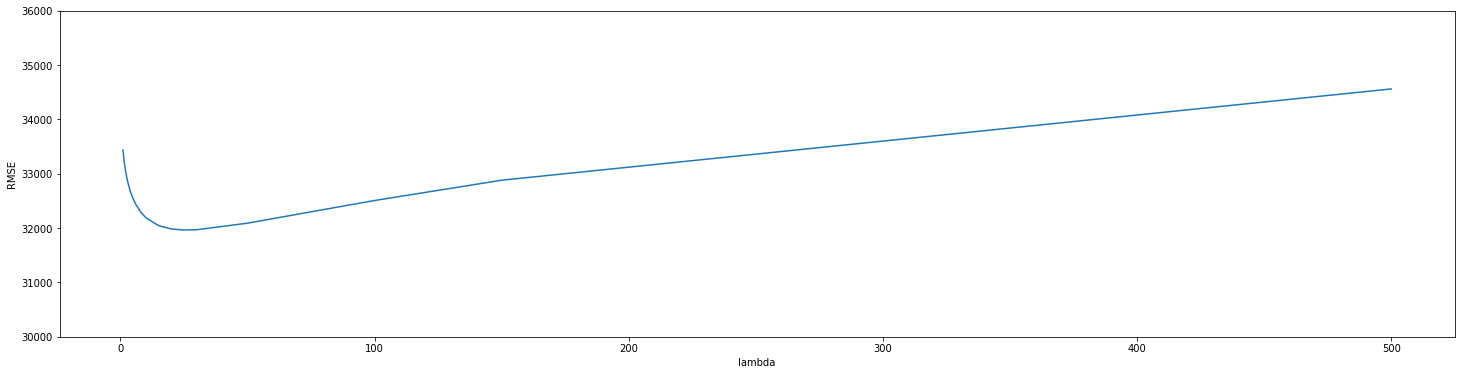

In [ ]:
# Figure
plt.figure(figsize=(25, 6))
plt.plot(lambdas, error)
plt.ylim((30000, 36000))
plt.xlabel('lambda')
plt.ylabel('RMSE')

Ridge regression model gives the best result with lambda = 25.

For the comparison; using the most suitable lambda value.

In [ ]:
model_ridge = Ridge(alpha = 25)
model_ridge.fit(train_X, train_y)

predictions_ridge = model_ridge.predict(val_X)
rmse_ridge = mean_squared_error(val_y, predictions_ridge, squared=False) #RMSE value
rmsle_ridge = mean_squared_log_error(val_y, predictions_ridge, squared=False) #RMSLE value

print(f'RMSE for Ridge regression is {rmse_ridge}')
print(f'RMSLE for Ridge regression is {rmsle_ridge}')

RMSE for Ridge regression is 30826.458593541796
RMSLE for Ridge regression is 0.13374734446575065


Ridge regression result for Kaggle.

In [ ]:
model_Ridge = Ridge(alpha = 25)
model_Ridge.fit(X_all, y_all)

test_y_predictions_ridge = model_Ridge.predict(test_df)

In [ ]:
submission_ridge = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_ridge},
    columns = ['Id', 'SalePrice'])
submission_ridge.to_csv('submission_ridge.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_ridge.csv -m "Ridge Regression submission"

100% 33.6k/33.6k [00:00<00:00, 130kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Score in Kaggle: 0.14416.

# 6. Decision tree and random forest

Next we will use decision tree and random forest algorithms. In case of the decision tree, we need to find the most suitable maximum depth of a tree and in case of the random forest, we need to find the most suitable number of trees. For that we will use cross-validation. 

## 6.1 Decision tree

In [ ]:
max_depths = [1, 2, 5, 8, 9, 10, 11, 12, 13, 15, 20, 30, 50, 100, 150, 300]

# let's collect RMSE values to find the best depth of the tree
error = np.zeros(len(max_depths))

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

for i, depth in enumerate(max_depths):

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into X_train, y_train and X_val, y_val depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the decision tree
    model = DecisionTreeRegressor(max_depth = depth)

    # fit the tree on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {depth} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

Average RMSE for 1 is 58708.46522911382
Average RMSE for 2 is 50166.73631237318
Average RMSE for 5 is 39507.88291735291
Average RMSE for 8 is 38823.13184967393
Average RMSE for 9 is 40226.164524996566
Average RMSE for 10 is 39262.91733804054
Average RMSE for 11 is 41142.39871148835
Average RMSE for 12 is 42473.27470372882
Average RMSE for 13 is 40745.57648800631
Average RMSE for 15 is 41467.53718004858
Average RMSE for 20 is 41768.625230837206
Average RMSE for 30 is 39275.96659442668
Average RMSE for 50 is 40157.81432078827
Average RMSE for 100 is 41567.34895919962
Average RMSE for 150 is 41076.372452806485
Average RMSE for 300 is 39833.68172281459


Text(0, 0.5, 'RMSE')

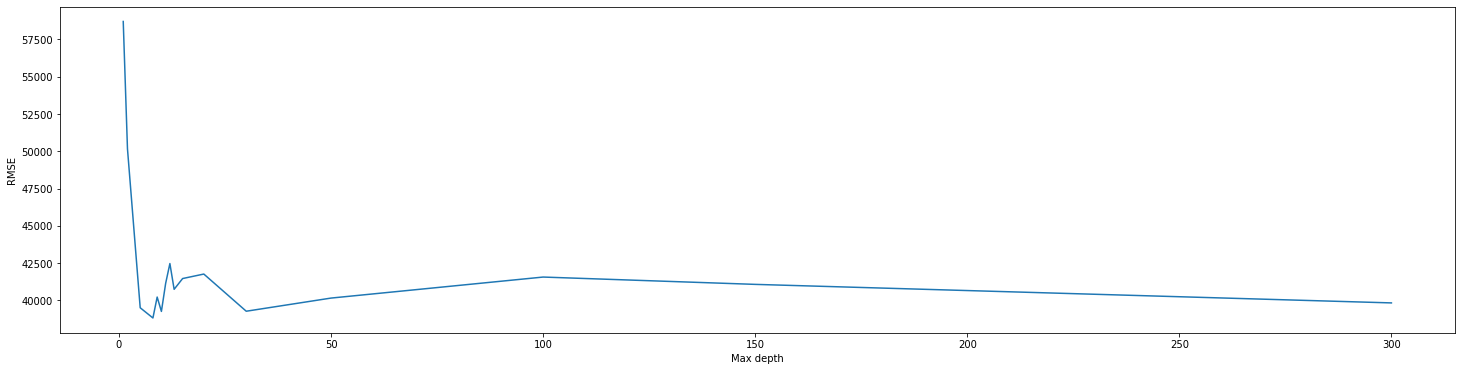

In [ ]:
# Figure
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

plt.plot(max_depths, error)
plt.xlabel('Max depth')
plt.ylabel('RMSE')


Based on the results, the most suitable maximum depth for a tree is 5.

For the comparison

In [ ]:
model_dt = DecisionTreeRegressor(max_depth = 5)
model_dt.fit(train_X, train_y)

predictions_dt = model_dt.predict(val_X)
rmse_dt = mean_squared_error(val_y, predictions_dt, squared=False) #RMSE value
rmsle_dt = mean_squared_log_error(val_y, predictions_dt, squared=False) #RMSLE value

print(f'RMSE for Decision tree is {rmse_dt}')
print(f'RMSLE for Decision tree is {rmsle_dt}')

RMSE for Decision tree is 45507.88911801241
RMSLE for Decision tree is 0.18787139723024748


Decision tree result for Kaggle.

In [ ]:
model_Dt = DecisionTreeRegressor(max_depth = 5)
model_Dt.fit(X_all, y_all)

test_y_predictions_dt = model_Dt.predict(test_df)

In [ ]:
submission_dt = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_dt},
    columns = ['Id', 'SalePrice'])
submission_dt.to_csv('submission_dt.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_dt.csv -m "Decision tree submission"

100% 31.2k/31.2k [00:01<00:00, 25.2kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Score in Kaggle: 0.21339

## 6.2 Random forest

In [ ]:
nr_trees = [50, 100, 500, 750, 1000]
#trees = [1000]

# let's collect RMSE values to find the best depth of the tree
error = np.zeros(len(nr_trees))

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

for i, tree in enumerate(nr_trees):

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into X_train, y_train and X_val, y_val depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train random forest
    model = RandomForestRegressor(n_estimators = tree)

    # fit the tree on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {tree} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

#Your session crashed after using all available RAM.

Average RMSE for 50 is 30165.294245578956
Average RMSE for 100 is 29533.563734528565
Average RMSE for 500 is 29599.32206836531
Average RMSE for 750 is 29392.639826477385
Average RMSE for 1000 is 29409.32353361701


Text(0, 0.5, 'RMSE')

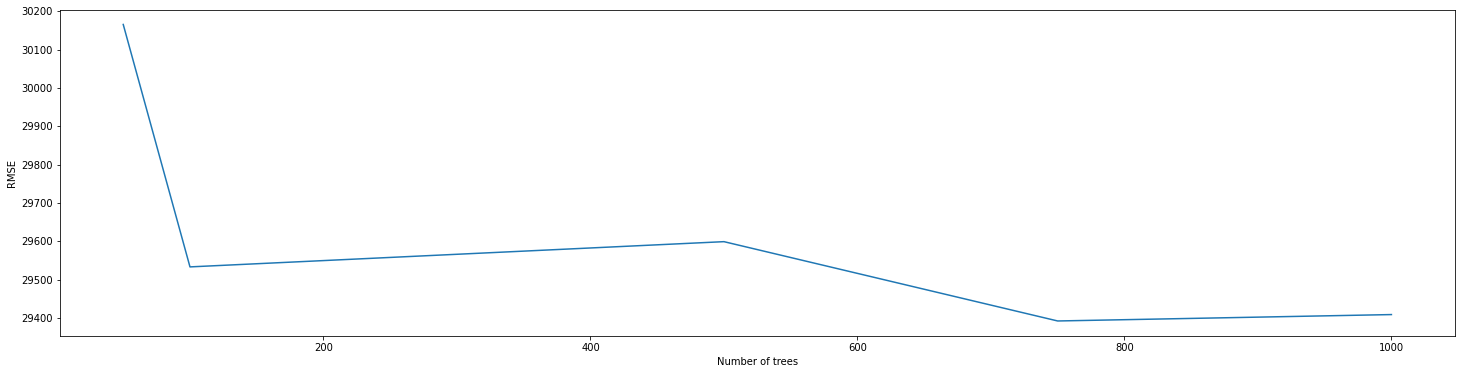

In [ ]:
# Figure
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 6))

plt.plot(nr_trees, error)
plt.xlabel('Number of trees')
plt.ylabel('RMSE')

Based on the results, we see that the most suitable number of trees in the forest is around 1000.

For the comparison

In [ ]:
model_rf = RandomForestRegressor(n_estimators = 750)
model_rf.fit(train_X, train_y)

predictions_rf = model_rf.predict(val_X)
rmse_rf = mean_squared_error(val_y, predictions_rf, squared=False) #RMSE value
rmsle_rf = mean_squared_log_error(val_y, predictions_rf, squared=False) #RMSLE value

print(f'RMSE for Random Forest is {rmse_rf}')
print(f'RMSLE for Random Forest is {rmsle_rf}')

RMSE for Random Forest is 29790.80316465151
RMSLE for Random Forest is 0.12462867360586291


Random forest result to Kaggle.

In [ ]:
model_rf = RandomForestRegressor(n_estimators=750)
model_rf.fit(X_all, y_all)

test_y_predictions_rf = model_rf.predict(test_df)

In [ ]:
submission_rf = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_rf},
    columns = ['Id', 'SalePrice'])
submission_rf.to_csv('submission_rf.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_rf.csv -m "Random Forest submission vol2"

100% 30.3k/30.3k [00:00<00:00, 144kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Score in Kaggle: 0.14522

# 7. Ensemble models

Ensemble model with linear regression, ridge, lasso and decision tree model. The parameters for the ridge, lasso and decision tree are chosen from the previous cross-validation results .

In [ ]:
#Define ensemble model with 4 models
model_lr = LinearRegression()
lambda_ridge=25
model_ridge = Ridge(lambda_ridge, max_iter=10000) 
lambda_lasso=150
model_lasso = Lasso(lambda_lasso, max_iter=10000)
model_DT = DecisionTreeRegressor(max_depth = 30)

model_lr.fit(train_X, train_y)
model_lasso.fit(train_X, train_y)
model_ridge.fit(train_X, train_y)
model_DT.fit(train_X, train_y)

ensemble_model = VotingRegressor(estimators=[('lr', model_lr), ('lasso', model_lasso), ('ridge', model_ridge), ('dt', model_DT)])
ensemble_model.fit(train_X,train_y)

val_predictions_ens = ensemble_model.predict(val_X)
ens_RMSE = mean_squared_error(val_y, val_predictions_ens, squared = False)
ens_RMSLE = mean_squared_log_error(val_y, val_predictions_ens, squared = False)

In [ ]:
#performance on validation set
print(f'Average validation RMSE for Ensemble is {ens_RMSE} and RMSLE is {ens_RMSLE}') 

Average validation RMSE for Ensemble is 28411.923644973245 and RMSLE is 0.12209615748007939


In [ ]:
#cross-validation
model_lr = LinearRegression()
# Ridge regression
lambda_ridge=25
model_ridge = Ridge(lambda_ridge, max_iter=10000) 
# Lasso 
lambda_lasso=150
model_lasso = Lasso(lambda_lasso, max_iter=10000)

model_DT = DecisionTreeRegressor(max_depth = 30)

n_folds = 4
fold_RMSEs = np.zeros(n_folds)

y = np.array(train_df2['SalePrice'])
X = np.array(train_df2.drop(['SalePrice'], axis = 1))

# initialise splitting mechanism
folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

# here actual splitting is done
folds.get_n_splits(X, y)

fold_indx = 1

# folds.split is an iterator that loops over different folds
# returning a tuple with train and val indeces
for train_index, val_index in folds.split(X, y):
  #print(f"CV #{fold_indx}")
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

  # train all three models
  model_lr.fit(X_train, y_train)
  model_lasso.fit(X_train, y_train)
  model_ridge.fit(X_train, y_train)
  model_DT.fit(X_train, y_train)

  ensemble_model = VotingRegressor(estimators=[('lr', model_lr), ('lasso', model_lasso), ('ridge', model_ridge), ('dt', model_DT)])
  ensemble_model.fit(X_train,y_train)

# Predict validation data using trained model

  val_predictions = ensemble_model.predict(X_val)
  fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions, squared = False)

  fold_indx += 1

print(f'Average validation RMSE is {np.mean(fold_RMSEs)}') 

Average validation RMSE is 31302.890709977644


Model on all train data.

In [ ]:
model_lr = LinearRegression()
lambda_ridge=25
model_ridge = Ridge(lambda_ridge, max_iter=10000) 
lambda_lasso=150
model_lasso = Lasso(lambda_lasso, max_iter=10000)
model_DT = DecisionTreeRegressor(max_depth = 30)

model_lr.fit(X_all, y_all)
model_lasso.fit(X_all, y_all)
model_ridge.fit(X_all, y_all)
model_DT.fit(X_all, y_all)

ensemble_model = VotingRegressor(estimators=[('lr', model_lr), ('lasso', model_lasso), ('ridge', model_ridge), ('dt', model_DT)])
ensemble_model.fit(X_all,y_all)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('lasso', Lasso(alpha=150, max_iter=10000)),
                            ('ridge', Ridge(alpha=25, max_iter=10000)),
                            ('dt', DecisionTreeRegressor(max_depth=30))])

In [ ]:
test_y_predictions_ens = ensemble_model.predict(test_df)

submission_ens = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_ens},
    columns = ['Id', 'SalePrice'])
submission_ens.to_csv('submission_ens.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_ens.csv -m "Ensemble submission"

100% 33.7k/33.7k [00:00<00:00, 108kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Result in Kaggle: 0.13625 (leaderboard place 1937)

# 8. Boosting and bagging methods

Next we will use Adaptive boosting, Bagging and Gradient boosting.
First we need to determine number of base estimators for bagging, maximum number of estimators at which boosting is terminated for adaptive boosting and number of boosting stages to perform for gradient boosting with cross-validation.

In [ ]:

n_estimators_Adap = [10,50,100,150, 200] 
n_estimators_Bag = [10,50,100,150,200] 
#n_estimators_GB = [100,125,150,175,200, 250,300,350,400,450,500]
#n_estimators = [500, 550, 600,650,700] 700: 24572
n_estimators = [550,650,750, 850,950] 

val_fold_abr = np.zeros(len(n_estimators))
val_fold_br = np.zeros(len(n_estimators))
val_fold_gbr = np.zeros(len(n_estimators))

for i, n_estimator in enumerate(n_estimators):
  print(f'Validation rmse for Adaptive Boosting with n_estimator = {n_estimators_Adap[i]}...')
  model_abr = AdaBoostRegressor(random_state=111,n_estimators=n_estimators_Adap[i])
  print(f'Validation rmse for Bagging with n_estimator = {n_estimators_Bag[i]}...')
  model_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=n_estimators_Bag[i], random_state=111)
  print(f'Validation rmse for Gradient Boosting with n_estimator = {n_estimator}...')
  model_gbr = GradientBoostingRegressor(random_state=111, n_estimators=n_estimator)

  n_folds = 4
  abr_fold_RMSEs = np.zeros(n_folds)
  br_fold_RMSEs = np.zeros(n_folds)
  gbr_fold_RMSEs = np.zeros(n_folds)

  y = np.array(train_df2['SalePrice'])
  X = np.array(train_df2.drop(['SalePrice'], axis = 1))

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    #print(f"CV #{fold_indx}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_abr.fit(X_train, y_train)
    model_br.fit(X_train, y_train)
    model_gbr.fit(X_train, y_train)


    val_predictions_abr = model_abr.predict(X_val)
    val_predictions_br = model_br.predict(X_val)
    val_predictions_gbr = model_gbr.predict(X_val)

    abr_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_abr, squared = False)
    br_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_br, squared = False)
    gbr_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_gbr, squared = False)

    fold_indx += 1

  print(f'Adaptive Boosting : average validation RMSE is {np.mean(abr_fold_RMSEs)}')
  #val_fold_abr = np.zeros(len(n_estimators))
  print(f'Bagging : average validation RMSE is {np.mean(br_fold_RMSEs)}')
  #val_fold_br = np.zeros(len(n_estimators))
  print(f'Gradient Boosting : average validation RMSE is {np.mean(gbr_fold_RMSEs)}')
  #val_fold_gbr = np.zeros(len(n_estimators))

Validation rmse for Adaptive Boosting with n_estimator = 10...
Validation rmse for Bagging with n_estimator = 10...
Validation rmse for Gradient Boosting with n_estimator = 550...
Adaptive Boosting : average validation RMSE is 38996.91971141417
Bagging : average validation RMSE is 30380.409287330294
Gradient Boosting : average validation RMSE is 25710.908979475847
Validation rmse for Adaptive Boosting with n_estimator = 50...
Validation rmse for Bagging with n_estimator = 50...
Validation rmse for Gradient Boosting with n_estimator = 650...
Adaptive Boosting : average validation RMSE is 35888.30316284752
Bagging : average validation RMSE is 29749.617073760717
Gradient Boosting : average validation RMSE is 25732.171440581275
Validation rmse for Adaptive Boosting with n_estimator = 100...
Validation rmse for Bagging with n_estimator = 100...
Validation rmse for Gradient Boosting with n_estimator = 750...
Adaptive Boosting : average validation RMSE is 36008.79425330003
Bagging : average v

Adaptive boosting give best result with n_estimators=50,
Bagging gives best result with n_estimators=100,
Gradient boosting gives best result with n_estimators=950. The smallest mean RMSE value with cross-validation we get with Gradient Boosting.

In [ ]:
#Validation set
model_abr = AdaBoostRegressor(n_estimators=50)
model_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)
model_gbr = GradientBoostingRegressor(n_estimators=950)

model_abr.fit(train_X, train_y)
model_br.fit(train_X, train_y)
model_gbr.fit(train_X, train_y)

val_predictions_abr = model_abr.predict(val_X)
val_predictions_br = model_br.predict(val_X)
val_predictions_gbr = model_gbr.predict(val_X)

abr_RMSE=mean_squared_error(val_y, val_predictions_abr, squared = False)
abr_RMSLE=mean_squared_log_error(val_y, val_predictions_abr, squared = False)
bag_RMSE=mean_squared_error(val_y, val_predictions_br, squared = False)
bag_RMSLE=mean_squared_log_error(val_y, val_predictions_br, squared = False)
gbr_RMSE=mean_squared_error(val_y, val_predictions_gbr, squared = False)
gbr_RMSLE=mean_squared_log_error(val_y, val_predictions_gbr, squared = False)

In [ ]:
print(f'The RMSE for Adaptive Boosting Regressor is {abr_RMSE} and the RMSLE is {abr_RMSLE}')
print(f'The RMSE for Bagging Regressor is {bag_RMSE} and the RMSLE is {bag_RMSLE}')
print(f'The RMSE for Gradient Boosting Regressor is {gbr_RMSE} and the RMSLE is {gbr_RMSLE}')

The RMSE for Adaptive Boosting Regressor is 35450.510041005124 and the RMSLE is 0.17278891010728586
The RMSE for Bagging Regressor is 30999.294181639125 and the RMSLE is 0.1257476514336841
The RMSE for Gradient Boosting Regressor is 28204.10698438384 and the RMSLE is 0.11391596020671486


Gradient boosting gives the smallest RMSE on validation set out of 3 models. I will only submit Bagging and Gradient Boosting result to Kaggle as they give better results than Adaptive boosting.

In [ ]:
model_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)
model_br.fit(X_all, y_all)
test_y_predictions_br = model_br.predict(test_df)

submission_br = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_br},
    columns = ['Id', 'SalePrice'])
submission_br.to_csv('submission_br.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_br.csv -m "Bagging submission"

100% 20.9k/20.9k [00:02<00:00, 9.42kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Bagging Kaggle score: 0.14602.

In [ ]:
model_gbr = GradientBoostingRegressor(n_estimators=950)
model_gbr.fit(X_all, y_all)

GradientBoostingRegressor(n_estimators=950)

In [ ]:
test_y_predictions_gbr = model_gbr.predict(test_df)

submission_gbr = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_gbr},
    columns = ['Id', 'SalePrice'])
submission_gbr.to_csv('submission_gbr.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_gbr.csv -m "Gradient Boosting submission"

100% 33.7k/33.7k [00:00<00:00, 158kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Result on Kaggle: 0.13436 (leaderboard place 1786).

## 8.1 XGBoost

In [ ]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html

model_xgb = xgb.XGBRegressor(objective='reg:squarederror')
# Fit the model using predictor X and response y.
model_xgb.fit(train_X, train_y)
#model_xgb.score(val_X,val_y)

print(f'XGBoost RMSE on validation set is {mean_squared_error(val_y, model_xgb.predict(val_X), squared = False) }')
print(f'XGBoost RMSLE on validation set is {mean_squared_log_error(val_y, model_xgb.predict(val_X), squared = False) }')

XGBoost RMSE on validation set is 31339.923168009067
XGBoost RMSLE on validation set is 0.12105189601887167


In [ ]:
#cross-validate n_estimators:
n_estimators = [50,100,200,500,750, 850] 

val_fold = np.zeros(len(n_estimators))

for i, n_estimator in enumerate(n_estimators):
  print(f'Validation rmse for XGboost with n_estimator = {n_estimator}...')
  model_xgb = xgb.XGBRegressor(n_estimators=n_estimator, random_state=111, objective= 'reg:squarederror')

  n_folds = 4
  fold_RMSEs = np.zeros(n_folds)

  y = np.array(train_df2['SalePrice'])
  X = np.array(train_df2.drop(['SalePrice'], axis = 1))

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    #print(f"CV #{fold_indx}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_xgb.fit(X_train, y_train)

    val_predictions = model_xgb.predict(X_val)

    fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions, squared = False)

    fold_indx += 1

  print(f'XGBoost : average validation RMSE is {np.mean(fold_RMSEs)}')


Validation rmse for XGboost with n_estimator = 50...
XGBoost : average validation RMSE is 29789.466104652627
Validation rmse for XGboost with n_estimator = 100...
XGBoost : average validation RMSE is 28012.13931016931
Validation rmse for XGboost with n_estimator = 200...
XGBoost : average validation RMSE is 27466.726465446693
Validation rmse for XGboost with n_estimator = 500...
XGBoost : average validation RMSE is 27136.477804669
Validation rmse for XGboost with n_estimator = 750...
XGBoost : average validation RMSE is 27068.444225097945
Validation rmse for XGboost with n_estimator = 850...
XGBoost : average validation RMSE is 27086.241242616434


We get best result with n_estimators=500.



In [ ]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)
# Fit the model using predictor X and response y.
model_xgb.fit(train_X, train_y)

print(f'XGBoost RMSE on validation set with n_estimators=500 is {mean_squared_error(val_y, model_xgb.predict(val_X), squared = False)} and RMSLE is {mean_squared_log_error(val_y, model_xgb.predict(val_X), squared = False) } ')

XGBoost RMSE on validation set with n_estimators=500 is 34794.2220875099 and RMSLE is 0.14226359583821727 


In [ ]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500)
model_xgb.fit(X_all, y_all)

XGBRegressor(n_estimators=500, objective='reg:squarederror')

In [ ]:
test_y_predictions_xgb = model_xgb.predict(test_df)

submission_xgb = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_xgb},
    columns = ['Id', 'SalePrice'])
submission_xgb.to_csv('submission_xgb2.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_xgb2.csv -m "XGBoost submission 2"

100% 21.2k/21.2k [00:04<00:00, 4.35kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle result: 0.13462 (with n_estimators=500); 0.13517 (with n_estimators=750)

# 9. Principal component analysis

In this chapter we will use Principal Component Analysis (PCA) to try to reduce the dimensionality of the data set and to improve the results of already tested models from before. 

## 9.1 PCA with only numerical variables

Here only the numerical variables of the dataset are used for the PCA. In the data set there were originally 32 numerical variables. However, "GarageYrBlt" and "Id" were removed in the beginning. 

In [26]:
# keeping only numerical variables, we are left with 30
train_num_only=X_all[['LotFrontage', 'MasVnrArea','LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold']]
# test set for Kaggle submissions
test_num_only=test_df[['LotFrontage', 'MasVnrArea','LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold']]

### 9.1.1 Different models 

Firstly, we will use some models from before with default parameters with PCA data. The models are the following: linear regression, decsision tree, random forest, gradient boosting and XGBoost.


In [27]:
# train and split to numerical train dataset 
train_X, val_X, train_y, val_y = train_test_split(train_num_only, np.array(y_all), 
                                                      random_state = 111, #set seed for randomness
                                                      test_size = 0.20)

In [28]:
train_X_num_stand = StandardScaler().fit_transform(train_X)
val_X_num_stand = StandardScaler().fit_transform(val_X)

pca = PCA(n_components=0.9) #choose the variance that we want to be described by PCs of the original variables 

# use PCA on our data
pca.fit(train_X_num_stand)

# train and validation set with PCA dimensionality reduction 
train_X_num_compressed=pca.transform(train_X_num_stand) # from 30 to 20
val_X_num_compressed=pca.transform(val_X_num_stand)

lr = LinearRegression() 
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
gbr = GradientBoostingRegressor()
xg = xgb.XGBRegressor(objective='reg:squarederror')

lr.fit(train_X_num_compressed, train_y)
dt.fit(train_X_num_compressed, train_y)
rf.fit(train_X_num_compressed, train_y)
gbr.fit(train_X_num_compressed, train_y)
xg.fit(train_X_num_compressed, train_y)

XGBRegressor(objective='reg:squarederror')

In [29]:
lr_rmse=np.round(mean_squared_error(val_y, lr.predict(val_X_num_compressed), squared=False),3)
dt_rmse=np.round(mean_squared_error(val_y, dt.predict(val_X_num_compressed), squared=False),3)
rf_rmse=np.round(mean_squared_error(val_y, rf.predict(val_X_num_compressed), squared=False),3)
gbr_rmse=np.round(mean_squared_error(val_y, gbr.predict(val_X_num_compressed), squared=False),3)
xg_rmse=np.round(mean_squared_error(val_y, xg.predict(val_X_num_compressed), squared=False),3)
lr_rmsle=np.round(mean_squared_log_error(val_y, lr.predict(val_X_num_compressed), squared=False),3)
dt_rmsle=np.round(mean_squared_log_error(val_y, dt.predict(val_X_num_compressed), squared=False),3)
rf_rmsle=np.round(mean_squared_log_error(val_y, rf.predict(val_X_num_compressed), squared=False),3)
gbr_rmsle=np.round(mean_squared_log_error(val_y, gbr.predict(val_X_num_compressed), squared=False),3)
xg_rmsle=np.round(mean_squared_log_error(val_y, xg.predict(val_X_num_compressed), squared=False),3)
print(f'The RMSE for Linear Regression with PCA is {lr_rmse} and the RMSLE is {lr_rmsle}')
print(f'The RMSE for Decision Tree Regressor with PCA is {dt_rmse} and the RMSLE is {dt_rmsle}')
print(f'The RMSE for Random Forest Regressor with PCA is {rf_rmse} and the RMSLE is {rf_rmsle}')
print(f'The RMSE for GradientBoosting with PCA is {gbr_rmse} and the RMSLE is {gbr_rmsle}')
print(f'The RMSE for XGBoost with PCA is {xg_rmse} and the RMSLE is {xg_rmsle}')

The RMSE for Linear Regression with PCA is 40386.008 and the RMSLE is 0.197
The RMSE for Decision Tree Regressor with PCA is 47683.062 and the RMSLE is 0.237
The RMSE for Random Forest Regressor with PCA is 33343.448 and the RMSLE is 0.149
The RMSE for GradientBoosting with PCA is 33394.135 and the RMSLE is 0.146
The RMSE for XGBoost with PCA is 33656.609 and the RMSLE is 0.149


### 9.1.2 Linear Regression

In [30]:
# The whole trainging set with only numerical variables with PCA dimensionality reduction is called train_all_num_compressed
train_all_num_stand = StandardScaler().fit_transform(train_num_only) #Standardize features by removing the mean and scaling to unit variance.

pca = PCA(n_components=0.9) 
pca.fit(train_all_num_stand)
train_all_num_compressed=pca.transform(train_all_num_stand) 

# Test set as well for the Kaggle competiton submission
test_num_stand = StandardScaler().fit_transform(test_num_only) #Standardize features by removing the mean and scaling to unit variance.
test_num_compressed=pca.transform(test_num_stand)

In [ ]:
lr = LinearRegression()
lr.fit(train_all_num_compressed, np.array(y_all))

test_y_predictions_lr = lr.predict(test_num_compressed)

submission_lr_pca1 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_lr},
    columns = ['Id', 'SalePrice'])
submission_lr_pca1.to_csv('submission_lr_pca1.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_lr_pca1.csv -m "Linear Regression with PCA1 Submission" #rmle 0.21052

100% 33.6k/33.6k [00:01<00:00, 33.7kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
#for final results
lr = LinearRegression()
lr.fit(train_X_num_compressed, train_y)
lr_rmse=np.round(mean_squared_error(val_y, lr.predict(val_X_num_compressed), squared=False),3)
lr_rmsle=np.round(mean_squared_log_error(val_y, lr.predict(val_X_num_compressed), squared=False),3)
print(f'The RMSE for Linear Regressor with PCA is {lr_rmse} and the RMSLE is {lr_rmsle}')


The RMSE for Linear Regressor with PCA is 40386.008 and the RMSLE is 0.197


### 9.1.3 Ridge Regression with cross-validaiton

Let's use cross-validation algorithm to find the best lambda value for the Ridge Regressor, which gives the smallest RMSE. We will use the Principal Components (PCs) of the numerical variables.

In [31]:
lambdas = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 8, 10, 15, 20, 25, 30, 50, 75, 100, 150, 500]

# let's collect RMSE values to find the best lambda
error = np.zeros(len(lambdas))

y = np.array(y_all)
X = train_all_num_compressed

for i, lambda_ in enumerate(lambdas):
  #print(f'RMSE for lambda = {lambda_}...')

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into X_train, y_train and X_val, y_val depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the Ridge regression model with lambda_
    model = Ridge(lambda_)

    # fit the Ridge regression on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {lambda_} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

Average RMSE for 1 is 40490.99996351876
Average RMSE for 1.5 is 40490.05878739794
Average RMSE for 2 is 40489.120811200526
Average RMSE for 2.5 is 40488.18602781081
Average RMSE for 3 is 40487.2544301373
Average RMSE for 3.5 is 40486.32601111255
Average RMSE for 4 is 40485.400763693164
Average RMSE for 4.5 is 40484.47868085958
Average RMSE for 5 is 40483.559755615985
Average RMSE for 6 is 40481.7313500337
Average RMSE for 8 is 40478.11212474516
Average RMSE for 10 is 40474.54264832047
Average RMSE for 15 is 40465.833776861036
Average RMSE for 20 is 40457.42652067792
Average RMSE for 25 is 40449.314473974984
Average RMSE for 30 is 40441.49143625617
Average RMSE for 50 is 40412.972064709174
Average RMSE for 75 is 40383.15735715689
Average RMSE for 100 is 40359.26299652576
Average RMSE for 150 is 40327.20014144036
Average RMSE for 500 is 40493.14137995026


The best lambda value is 150. Let's submit it to Kaggle. 

In [32]:
ridge=Ridge(150)
ridge.fit(train_all_num_compressed, np.array(y_all))

test_y_predictions_ridge = ridge.predict(test_num_compressed)

submission_ridge_pca1 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_ridge},
    columns = ['Id', 'SalePrice'])
submission_ridge_pca1.to_csv('submission_ridge_pca1.csv', index = False)

In [33]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_ridge_pca1.csv -m "Ridge Regression with PCA1 Submission" #rmle 0.19926

100% 33.6k/33.6k [00:02<00:00, 13.1kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score is 0.19926.

In [34]:
#for final results
ridge = Ridge(150)
ridge.fit(train_X_num_compressed, train_y)
ridge_rmse=np.round(mean_squared_error(val_y, ridge.predict(val_X_num_compressed), squared=False),3)
ridge_rmsle=np.round(mean_squared_log_error(val_y, ridge.predict(val_X_num_compressed), squared=False),3)
print(f'The RMSE for Ridge Regressor with PCA is {ridge_rmse} and the RMSLE is {ridge_rmsle}')

The RMSE for Ridge Regressor with PCA is 40613.058 and the RMSLE is 0.187


### 9.1.4 Decision Tree Regressor with cross-validation

Let's use cross-validation algorithm to find the best depth for the Decision Tree Regressor, which gives the smallest RMSE. We will use the Principal Components (PCs) of the numerical variables.

In [ ]:
n_depths = [5,10,15,20,25,30,35,40,45,50,60,70,90,100]
mean_RMSEs = np.zeros(len(n_depths))

for i, depth in enumerate(n_depths):

  n_folds = 4
  dt_fold_RMSEs = np.zeros(n_folds)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 
  # here actual splitting is done
  X=train_all_num_compressed
  y=np.array(y_all)
  folds.get_n_splits(X, y)

  fold_indx = 1

  dt_model=DecisionTreeRegressor(max_depth=depth)

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the models
    dt_model.fit(X_train, y_train)
    dt_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, dt_model.predict(X_val), squared = False)

    fold_indx += 1

  print(f'Average validation RMSE for DT with maximal possible depth of {depth} with PCA is {np.round(np.mean(dt_fold_RMSEs),3)}') 
  mean_RMSEs[i] = np.mean(dt_fold_RMSEs)

Average validation RMSE for DT with maximal possible depth of 5 with PCA is 44738.23
Average validation RMSE for DT with maximal possible depth of 10 with PCA is 46260.015
Average validation RMSE for DT with maximal possible depth of 15 with PCA is 47237.252
Average validation RMSE for DT with maximal possible depth of 20 with PCA is 46460.202
Average validation RMSE for DT with maximal possible depth of 25 with PCA is 45149.893
Average validation RMSE for DT with maximal possible depth of 30 with PCA is 47100.828
Average validation RMSE for DT with maximal possible depth of 35 with PCA is 46436.848
Average validation RMSE for DT with maximal possible depth of 40 with PCA is 45038.507
Average validation RMSE for DT with maximal possible depth of 45 with PCA is 47418.414
Average validation RMSE for DT with maximal possible depth of 50 with PCA is 46652.297
Average validation RMSE for DT with maximal possible depth of 60 with PCA is 48365.27
Average validation RMSE for DT with maximal po

Best is Decision Tree Regressor with max depth of 5, the RMSE is 44 738.23.

Submitting to Kaggle the best Decision Tree Regressor with maximum depth of 5.

In [ ]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_all_num_compressed, np.array(y_all))

test_y_predictions_dt = dt.predict(test_num_compressed)

submission_dt_pca1 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_dt},
    columns = ['Id', 'SalePrice'])
submission_dt_pca1.to_csv('submission_dt_pca1.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_dt_pca1.csv -m "Decision Tree with PCA1 Submission" #rmle 0.20865

Kaggle score is 0.20865.

In [ ]:
#for final results
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_X_num_compressed, train_y)
dt_rmse=np.round(mean_squared_error(val_y, dt.predict(val_X_num_compressed), squared=False),3)
dt_rmsle=np.round(mean_squared_log_error(val_y, dt.predict(val_X_num_compressed), squared=False),3)
print(f'The RMSE for Decision Tree Regressor with PCA is {dt_rmse} and the RMSLE is {dt_rmsle}')


The RMSE for Decision Tree Regressor with PCA is 36829.515 and the RMSLE is 0.176


### 9.1.5 Random Forest with cross-validation 

Let's use cross-validation alogrithm to find a number of trees, which has the smallest RMSE for Random Forest Regressor. We will use the Principal Components as the variables. 

In [ ]:
n_trees = [5,10,50,100,200,500,1000]
mean_RMSEs = np.zeros(len(n_trees))

for i, trees in enumerate(n_trees):

  n_folds = 4
  rf_fold_RMSEs = np.zeros(n_folds)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 
  # here actual splitting is done
  X=train_all_num_compressed
  y=np.ravel(np.array(y_all))
  folds.get_n_splits(X, y)

  fold_indx = 1

  rf_model=RandomForestRegressor(n_estimators=trees) #number of trees in the forest 

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model.fit(X_train, y_train)
    rf_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, rf_model.predict(X_val), squared = False)
    fold_indx += 1

  print(f'Average validation RMSE for RF with number of trees of {trees} with PCA is {np.round(np.mean(rf_fold_RMSEs),3)}') 
  mean_RMSEs[i] = np.mean(rf_fold_RMSEs)

Average validation RMSE for RF with number of trees of 5 with PCA is 38271.402
Average validation RMSE for RF with number of trees of 10 with PCA is 37567.144
Average validation RMSE for RF with number of trees of 50 with PCA is 35726.225
Average validation RMSE for RF with number of trees of 100 with PCA is 35693.874
Average validation RMSE for RF with number of trees of 200 with PCA is 35472.778
Average validation RMSE for RF with number of trees of 500 with PCA is 35309.1
Average validation RMSE for RF with number of trees of 1000 with PCA is 35369.77


Text(0.5, 1.0, 'CV of RF Regressor')

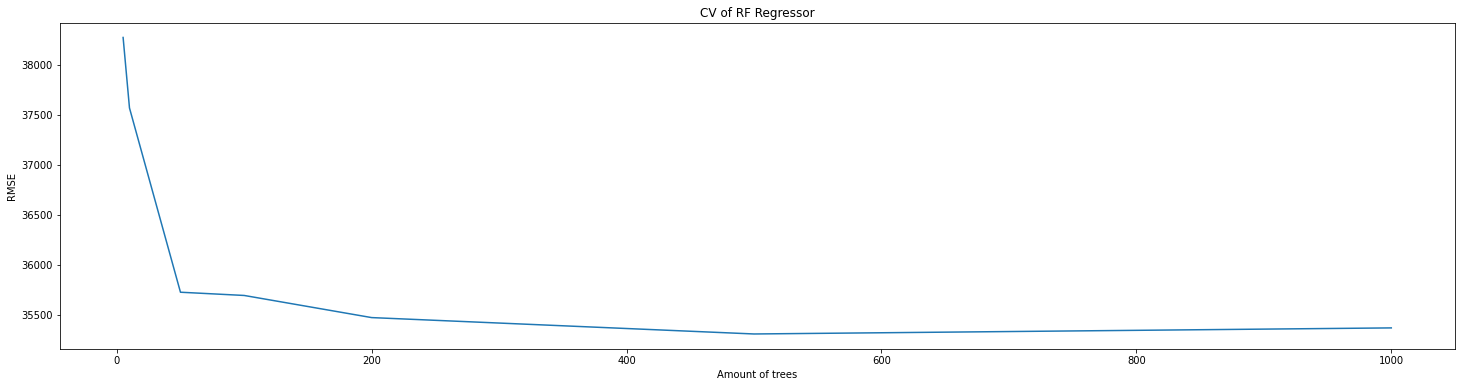

In [ ]:
plt.figure(figsize=(25, 6)) 
plt.plot(n_trees,mean_RMSEs)
plt.xlabel('Amount of trees')
plt.ylabel('RMSE')
plt.title('CV of RF Regressor')

Best is Random Forest Regressor with maximum number of trees is 500, the RMSE is 35 309.1.

Submitting to Kaggle the best model.

In [ ]:
rf = RandomForestRegressor(n_estimators=500)
rf.fit(train_all_num_compressed, np.array(y_all))

test_y_predictions_rf = rf.predict(test_num_compressed)

submission_rf_pca1 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_rf},
    columns = ['Id', 'SalePrice'])
submission_rf_pca1.to_csv('submission_rf_pca1.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_rf_pca1.csv -m "Random Forest with PCA1 Submission" #rmle 0.18594

100% 23.4k/23.4k [00:00<00:00, 89.9kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
# for final results 
rf= RandomForestRegressor(n_estimators=500)
rf.fit(train_X_num_compressed, train_y)
rf_rmse=np.round(mean_squared_error(val_y, rf.predict(val_X_num_compressed), squared=False),3)
rf_rmsle=np.round(mean_squared_log_error(val_y, rf.predict(val_X_num_compressed), squared=False),3)
print(f'The RMSE for Random Forest Regressor with PCA1 is {rf_rmse} and the RMSLE is {rf_rmsle}')

The RMSE for Random Forest Regressor with PCA1 is 33880.495 and the RMSLE is 0.149


### 9.1.6 Bagging with cross-validation

In [ ]:
n_estimators = [100,200,400,600,800] 

for i, n_estimator in enumerate(n_estimators):
  model_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=n_estimator)

  n_folds = 4
  br_fold_RMSEs = np.zeros(n_folds)

  X=train_all_num_compressed
  y=np.ravel(np.array(train_df2[['SalePrice']]))

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_br.fit(X_train, y_train)

    val_predictions_br = model_br.predict(X_val)

    br_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_br, squared = False)

    fold_indx += 1

  print(f'Bagging : average validation RMSE with n_estimators = {n_estimator} is {np.mean(br_fold_RMSEs)}')

Bagging : average validation RMSE with n_estimators = 100 is 35109.2631459737
Bagging : average validation RMSE with n_estimators = 200 is 35467.792860763155
Bagging : average validation RMSE with n_estimators = 400 is 35363.345121313454
Bagging : average validation RMSE with n_estimators = 600 is 35239.12541534918
Bagging : average validation RMSE with n_estimators = 800 is 35312.19552983507


The best result is with n_estimators=100

In [ ]:
m_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)
m_br.fit(train_X_num_compressed, train_y)
val_pred_br_pca1=m_br.predict(val_X_num_compressed)
br_rmse2=np.round(mean_squared_error(val_y, val_pred_br_pca1, squared=False),3)
br_rmsle2=np.round(mean_squared_log_error(val_y, val_pred_br_pca1, squared=False),3)
print(f'The RMSE for Bagging with n_estimators=100 is {br_rmse2} and the RMSLE is {br_rmsle2}')

The RMSE for Bagging with n_estimators=100 is 34468.796 and the RMSLE is 0.15


In [ ]:
m_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100)
m_br.fit(train_all_num_compressed, np.ravel(np.array(train_df2[['SalePrice']])))

test_y_predictions_br2 = m_br.predict(test_num_compressed)

submission_br2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_br2},
    columns = ['Id', 'SalePrice'])
submission_br2.to_csv('submission_br2.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_br2.csv -m "Bagging Submission PCA"

100% 21.2k/21.2k [00:01<00:00, 13.4kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.18618

### 9.1.7 Gradient Boosting with cross-validation

In [ ]:
n_estimators = [100,200,400,600,800] 

for i, n_estimator in enumerate(n_estimators):
  model_gbr = GradientBoostingRegressor(n_estimators=n_estimator)

  n_folds = 4
  gbr_fold_RMSEs = np.zeros(n_folds)

  X=train_all_num_compressed
  y=np.ravel(np.array(train_df2[['SalePrice']]))

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_gbr.fit(X_train, y_train)

    val_predictions_gbr = model_gbr.predict(X_val)

    gbr_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_gbr, squared = False)

    fold_indx += 1

  print(f'Gradient Boosting : average validation RMSE with n_estimators = {n_estimator} is {np.mean(gbr_fold_RMSEs)}')

Gradient Boosting : average validation RMSE with n_estimators = 100 is 35940.538496193956
Gradient Boosting : average validation RMSE with n_estimators = 200 is 35818.33293716846
Gradient Boosting : average validation RMSE with n_estimators = 400 is 35583.27529719673
Gradient Boosting : average validation RMSE with n_estimators = 600 is 35719.191108178464
Gradient Boosting : average validation RMSE with n_estimators = 800 is 35807.071822827726


The best result is with n_estimators=400.

In [ ]:
m_gbr = GradientBoostingRegressor(n_estimators=400)

m_gbr.fit(train_X_num_compressed, train_y)
val_pred_gbr_pca1=m_gbr.predict(val_X_num_compressed)
gbr_rmse2=np.round(mean_squared_error(val_y, val_pred_gbr_pca1, squared=False),3)
gbr_rmsle2=np.round(mean_squared_log_error(val_y, val_pred_gbr_pca1, squared=False),3)
print(f'The RMSE for GradientBoosting with n_estimators=400 is {gbr_rmse2} and the RMSLE is {gbr_rmsle2}')

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The RMSE for GradientBoosting with n_estimators=400 is 33972.69 and the RMSLE is 0.15


In [ ]:
m_gbr = GradientBoostingRegressor(n_estimators=400)
m_gbr.fit(train_all_num_compressed, np.array(train_df2[['SalePrice']]))

test_y_predictions_gbr2 = m_gbr.predict(test_num_compressed)

submission_gbr2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_gbr2},
    columns = ['Id', 'SalePrice'])
submission_gbr2.to_csv('submission_gbr2.csv', index = False)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_gbr2.csv -m "Gradient Boosting Submission PCA"

100% 33.6k/33.6k [00:05<00:00, 6.72kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.18376.

### 9.1.8 XGBoost with cross-validation

In [ ]:
n_estimators = [50,100,200,500,750, 850] 

val_fold = np.zeros(len(n_estimators))

for i, n_estimator in enumerate(n_estimators):
  model_xgb = xgb.XGBRegressor(n_estimators=n_estimator, objective= 'reg:squarederror')

  n_folds = 4
  fold_RMSEs = np.zeros(n_folds)

  X=train_all_num_compressed
  y=np.ravel(np.array(train_df2[['SalePrice']]))

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    #print(f"CV #{fold_indx}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_xgb.fit(X_train, y_train)


    val_predictions = model_xgb.predict(X_val)

    fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions, squared = False)

    fold_indx += 1

  print(f'XGBoost with n_estimator = {n_estimator} average validation RMSE is {np.mean(fold_RMSEs)}')

XGBoost with n_estimator = 50 average validation RMSE is 36209.03502179776
XGBoost with n_estimator = 100 average validation RMSE is 35668.03095563523
XGBoost with n_estimator = 200 average validation RMSE is 35246.636952508896
XGBoost with n_estimator = 500 average validation RMSE is 35212.38104098234
XGBoost with n_estimator = 750 average validation RMSE is 35284.81309190783
XGBoost with n_estimator = 850 average validation RMSE is 35311.55895191759


The best result is with n_estimators=500.

In [ ]:
m_xgb = xgb.XGBRegressor(n_estimators=500,objective= 'reg:squarederror')
m_xgb.fit(train_X_num_compressed, train_y)
val_pred_xgb_pca1=m_gbr.predict(val_X_num_compressed)

xgb_rmse2=np.round(mean_squared_error(val_y, val_pred_xgb_pca1, squared=False),3)
xgb_rmsle2=np.round(mean_squared_log_error(val_y, val_pred_xgb_pca1, squared=False),3)
print(f'The RMSE for XGBoost with n_estimators=500 is {xgb_rmse2} and the RMSLE is {xgb_rmsle2}')

The RMSE for XGBoost with n_estimators=500 is 28414.83 and the RMSLE is 0.15


In [ ]:
m_xgb = xgb.XGBRegressor(n_estimators=500,objective= 'reg:squarederror')
m_xgb.fit(train_all_num_compressed, np.array(train_df2[['SalePrice']]))

test_y_predictions_xgb2 = m_xgb.predict(test_num_compressed)

submission_xgb2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_xgb2},
    columns = ['Id', 'SalePrice'])
submission_xgb2.to_csv('submission_xgb2.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_xgb2.csv -m "XGBoost Submission PCA"

100% 21.2k/21.2k [00:04<00:00, 4.68kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.18291. Wins Gradient Boosting PCA submission and simple linear regression submission.

## 9.2 PCA with numerical variables and categorical variables added as dummy variables

In this second section of PCA in addition to PCs of numerical variables the dummy variables are added afterwards to the data set. The dummy variables are not used in the PCA dimensinality reduction. 


### 9.2.1 Different models 

We will use some models from before with default parameters with PCA data. The models are the following: Ridge regression, decsision tree, random forest, gradient boosting and XGBoost.

With this second PCA data set we could not make a reasonable model for linear regression, thus we eliminated it from our report. 

In [39]:
#splitting the data into train and validation
train_X, val_X, train_y, val_y = train_test_split(X_all, y_all, 
                                                      random_state = 111, 
                                                      test_size = 0.20)

# splitting train_X and val_X into two subsets: numerical columns and categorical columns 
train_X_num =train_X[['LotFrontage', 'MasVnrArea','LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold','MSSubClass',	'OverallQual',	'OverallCond',	'YearBuilt']]
val_X_num=val_X[['LotFrontage', 'MasVnrArea','LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold','MSSubClass',	'OverallQual',	'OverallCond',	'YearBuilt']]

num_columns = ['LotFrontage', 'MasVnrArea', 'LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold','MSSubClass',	'OverallQual',	'OverallCond',	'YearBuilt']
train_X_cat = train_X
val_X_cat = val_X
for col in num_columns:
  train_X_cat = train_X_cat.drop([col], axis = 1)
  val_X_cat = val_X_cat.drop([col], axis = 1)

In [40]:
train_num_stand = StandardScaler().fit_transform(train_X_num)
val_num_stand = StandardScaler().fit_transform(val_X_num)

pca = PCA(n_components=0.9) #choose the variance that we want to be described by PCs of the original variables 

# use PCA on our data
pca.fit(train_num_stand)

train_num_compressed=pca.transform(train_num_stand)
val_num_compressed=pca.transform(val_num_stand)

# put together the two subsets: numerical with PCA and catgeorical as dummies
train_X_num_pca=pd.DataFrame(train_num_compressed, columns=['PCA%i' % i for i in range(train_num_compressed.shape[1])])
train_X_num_pca.index=train_X_cat.index
train_X_mix_all=pd.concat([train_X_num_pca,train_X_cat], axis=1)

val_X_num_pca=pd.DataFrame(val_num_compressed, columns=['PCA%i' % i for i in range(val_num_compressed.shape[1])])
val_X_num_pca.index=val_X_cat.index
val_X_mix_all=pd.concat([val_X_num_pca, val_X_cat], axis=1) 

ridge = Ridge()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
xg = xgb.XGBRegressor(objective='reg:squarederror')
gbr = GradientBoostingRegressor()

ridge.fit(train_X_mix_all, train_y)
dt.fit(train_X_mix_all, train_y)
rf.fit(train_X_mix_all, train_y)
gbr.fit(train_X_mix_all, train_y)
xg.fit(train_X_mix_all, train_y)

XGBRegressor(objective='reg:squarederror')

In [41]:
ridge_rmse=np.round(mean_squared_error(val_y, ridge.predict(val_X_mix_all), squared=False),3)
dt_rmse=np.round(mean_squared_error(val_y, dt.predict(val_X_mix_all), squared=False),3)
rf_rmse=np.round(mean_squared_error(val_y, rf.predict(val_X_mix_all), squared=False),3)
gbr_rmse=np.round(mean_squared_error(val_y, gbr.predict(val_X_mix_all), squared=False),3)
xg_rmse=np.round(mean_squared_error(val_y, xg.predict(val_X_mix_all), squared=False),3)
ridge_rmsle=np.round(mean_squared_log_error(val_y, ridge.predict(val_X_mix_all), squared=False),3)
dt_rmsle=np.round(mean_squared_log_error(val_y, dt.predict(val_X_mix_all), squared=False),3)
rf_rmsle=np.round(mean_squared_log_error(val_y, rf.predict(val_X_mix_all), squared=False),3)
gbr_rmsle=np.round(mean_squared_log_error(val_y, gbr.predict(val_X_mix_all), squared=False),3)
xg_rmsle=np.round(mean_squared_log_error(val_y, xg.predict(val_X_mix_all), squared=False),3)
print(f'The RMSE for Ridge Regressor with PCA is {ridge_rmse} and the RMSLE is {ridge_rmsle}')
print(f'The RMSE for Decision Tree Regressor with PCA is {dt_rmse} and the RMSLE is {dt_rmsle}')
print(f'The RMSE for Random Forest Regressor with PCA is {rf_rmse} and the RMSLE is {rf_rmsle}')
print(f'The RMSE for Gradient Boosting Regressor with PCA is {gbr_rmse} and the RMSLE is {gbr_rmsle}')
print(f'The RMSE for XGBoost with PCA is {xg_rmse} and the RMSLE is {xg_rmsle}')

The RMSE for Ridge Regressor with PCA is 33190.268 and the RMSLE is 0.156
The RMSE for Decision Tree Regressor with PCA is 40867.091 and the RMSLE is 0.181
The RMSE for Random Forest Regressor with PCA is 31278.015 and the RMSLE is 0.126
The RMSE for Gradient Boosting Regressor with PCA is 29765.362 and the RMSLE is 0.122
The RMSE for XGBoost with PCA is 30422.195 and the RMSLE is 0.123


### 9.2.2 Ridge regression with cross-validation

For the cross-validaiton algorith the whole of the trainging data set is used. 

In [35]:
# whole training data
num_columns = ['LotFrontage', 'MasVnrArea', 'LotArea', 'YearRemodAdd','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','TotRmsAbvGrd','Fireplaces','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','BedroomAbvGr',	'KitchenAbvGr','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold','MSSubClass',	'OverallQual',	'OverallCond',	'YearBuilt']
train_X_cat = X_all
for col in num_columns:
  train_X_cat = train_X_cat.drop([col], axis = 1)

train_num_stand = StandardScaler().fit_transform(train_num_only)
pca = PCA(n_components=0.9) 
pca.fit(train_num_stand)

train_num_compressed=pca.transform(train_num_stand)

# put together the two subsets: numerical with PCA and catgeorical as dummies
train_X_num_pca=pd.DataFrame(train_num_compressed, columns=['PCA%i' % i for i in range(train_num_compressed.shape[1])])
train_X_num_pca.index=train_X_cat.index
train_mix_all=pd.concat([train_X_num_pca,train_X_cat], axis=1)

#For Test data same way 
test_cat = test_df
for col in num_columns:
  test_cat = test_cat.drop([col], axis = 1)

test_num_stand2 = StandardScaler().fit_transform(test_num_only) #Standardize features by removing the mean and scaling to unit variance.
test_num_compressed2=pca.transform(test_num_stand2)

# put together the two subsets: numerical with PCA and catgeorical as dummies
test_num_pca=pd.DataFrame(test_num_compressed2, columns=['PCA%i' % i for i in range(test_num_compressed2.shape[1])])
test_num_pca.index=test_cat.index
test_mix_all=pd.concat([test_num_pca,test_cat], axis=1)

In [37]:
lambdas = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6, 8, 10, 15, 20, 25, 30, 50, 75, 100, 150, 500]

# let's collect RMSE values to find the best lambda
error = np.zeros(len(lambdas))

y = np.array(y_all)
X = np.array(train_mix_all)

for i, lambda_ in enumerate(lambdas):
  #print(f'RMSE for lambda = {lambda_}...')

  # 4-fold cross validation
  # Here we are using sklearn Cross Validation Function called KFold
  kf = KFold(n_splits=4, random_state=111, shuffle=True)

  # We initialize empty lists
  fold_rmse = []
  for train_index, val_index in kf.split(X):

    # split data into X_train, y_train and X_val, y_val depending on the fold:
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train the Ridge regression model with lambda_
    model = Ridge(lambda_)

    # fit the Ridge regression on training data
    model.fit(X_train, y_train) 

    # predictions on validation data
    predictions = model.predict(X_val)

    # calculate RMSE for this fold and store it in fold_rmse
    error_rmse = mean_squared_error(y_val, predictions, squared=False)
    fold_rmse.append(error_rmse)

  print(f'Average RMSE for {lambda_} is {np.mean(fold_rmse)}')
  error[i] = np.mean(fold_rmse)

Average RMSE for 1 is 34401.72347663342
Average RMSE for 1.5 is 34132.943769147234
Average RMSE for 2 is 33942.63269556362
Average RMSE for 2.5 is 33798.32071923768
Average RMSE for 3 is 33683.76503678208
Average RMSE for 3.5 is 33589.93880652728
Average RMSE for 4 is 33511.37756719108
Average RMSE for 4.5 is 33444.53854052037
Average RMSE for 5 is 33386.99484111226
Average RMSE for 6 is 33293.28924881286
Average RMSE for 8 is 33164.221293652285
Average RMSE for 10 is 33084.10876796383
Average RMSE for 15 is 32996.196295349546
Average RMSE for 20 is 32988.2192745817
Average RMSE for 25 is 33017.30176795459
Average RMSE for 30 is 33065.25101292324
Average RMSE for 50 is 33318.193938113036
Average RMSE for 75 is 33639.67326118902
Average RMSE for 100 is 33926.45111610446
Average RMSE for 150 is 34401.375516409986
Average RMSE for 500 is 36212.829988654325


Submission to Kaggle with the best lambda value of 20.

In [43]:
ridge= Ridge(20)
ridge.fit(train_mix_all, np.array(y_all))

test_y_predictions_ridge = ridge.predict(test_mix_all)

submission_ridge_pca2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_ridge},
    columns = ['Id', 'SalePrice'])
submission_ridge_pca2.to_csv('submission_ridge_pca2.csv', index = False)

In [44]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_ridge_pca2.csv -m "Ridge + PCA2 Submission" #rmle 0.16021

100% 33.6k/33.6k [00:03<00:00, 9.12kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score is 0.16021.

In [42]:
#for final results
ridge = Ridge(alpha=20)
ridge.fit(train_X_mix_all, train_y)
ridge_rmse=np.round(mean_squared_error(val_y, ridge.predict(val_X_mix_all), squared=False),3)
ridge_rmsle=np.round(mean_squared_log_error(val_y, ridge.predict(val_X_mix_all), squared=False),3)
print(f'The RMSE for Ridge Regressor with PCA is {ridge_rmse} and the RMSLE is {ridge_rmsle}')

The RMSE for Ridge Regressor with PCA is 32737.52 and the RMSLE is 0.143


### 9.2.3 Decision Tree with cross-validation

In [ ]:
n_depths = [5,10,15,20,25,30,35,40,45,50,60,70,80,90]
mean_RMSEs = np.zeros(len(n_depths))

for i, depth in enumerate(n_depths):

  n_folds = 4
  dt_fold_RMSEs = np.zeros(n_folds)

  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  X=np.array(train_mix_all)
  y=np.array(y_all)
  folds.get_n_splits(X, y)

  fold_indx = 1

  dt_model=DecisionTreeRegressor(max_depth=depth)

  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    dt_model.fit(X_train, y_train)
    dt_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, dt_model.predict(X_val), squared = False)

    fold_indx += 1

  print(f'Average validation RMSE for DT with maximal possible depth of {depth} with PCA is {np.round(np.mean(dt_fold_RMSEs),3)}') 
  mean_RMSEs[i] = np.mean(dt_fold_RMSEs)

Average validation RMSE for DT with maximal possible depth of 5 with PCA is 41358.495
Average validation RMSE for DT with maximal possible depth of 10 with PCA is 44218.375
Average validation RMSE for DT with maximal possible depth of 15 with PCA is 47435.675
Average validation RMSE for DT with maximal possible depth of 20 with PCA is 45770.013
Average validation RMSE for DT with maximal possible depth of 25 with PCA is 45491.699
Average validation RMSE for DT with maximal possible depth of 30 with PCA is 45776.904
Average validation RMSE for DT with maximal possible depth of 35 with PCA is 44134.605
Average validation RMSE for DT with maximal possible depth of 40 with PCA is 47546.848
Average validation RMSE for DT with maximal possible depth of 45 with PCA is 47809.209
Average validation RMSE for DT with maximal possible depth of 50 with PCA is 48972.648
Average validation RMSE for DT with maximal possible depth of 60 with PCA is 44103.718
Average validation RMSE for DT with maximal 

Text(0.5, 1.0, 'CV of DT Regressor')

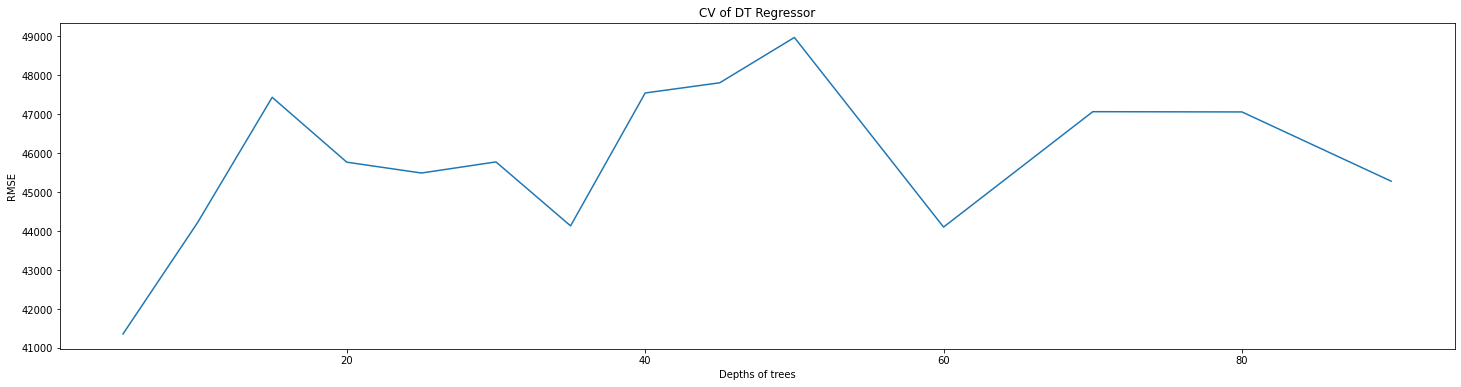

In [ ]:
plt.figure(figsize=(25, 6)) 
plt.plot(n_depths,mean_RMSEs)
plt.xlabel('Depths of trees')
plt.ylabel('RMSE')
plt.title('CV of DT Regressor')

Best Decision Tree Regressor is with max depth of 5, its RMSE is 41 358.495.

Submitting to Kaggle the best Decision Tree with maximum depth of 5 

In [ ]:
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_mix_all, np.array(y_all))

test_y_predictions_dt = dt.predict(test_mix_all)

submission_dt_pca2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_dt},
    columns = ['Id', 'SalePrice'])
submission_dt_pca2.to_csv('submission_dt_pca2.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_dt_pca2.csv -m "Decision Tree + PCA2 Submission" #rmle 0.19796

100% 32.9k/32.9k [00:01<00:00, 20.2kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score is 0.19796

In [ ]:
#for final results
dt = DecisionTreeRegressor(max_depth=5)
dt.fit(train_X_mix_all, train_y)
dt_rmse=np.round(mean_squared_error(val_y, dt.predict(val_X_mix_all), squared=False),3)
dt_rmsle=np.round(mean_squared_log_error(val_y, dt.predict(val_X_mix_all), squared=False),3)
print(f'The RMSE for Decision Tree Regressor with PCA is {dt_rmse} and the RMSLE is {dt_rmsle}')

The RMSE for Decision Tree Regressor with PCA is 36218.475 and the RMSLE is 0.159


### 9.2.4 Random Forest with cross-validation

In [ ]:
n_trees = [5,10,50,100,200,500,1000]
mean_RMSEs = np.zeros(len(n_trees))

for i, trees in enumerate(n_trees):

  n_folds = 4
  rf_fold_RMSEs = np.zeros(n_folds)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  X=np.array(train_mix_all)
  y=np.ravel(y_all)
  folds.get_n_splits(X, y)

  fold_indx = 1

  rf_model=RandomForestRegressor(n_estimators=trees)

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    rf_model.fit(X_train, y_train)
    rf_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, rf_model.predict(X_val), squared = False)

    fold_indx += 1

  print(f'Average validation RMSE for RF with maximal possible nr of trees of {trees} with PCA is {np.mean(rf_fold_RMSEs)}') 
  mean_RMSEs[i] = np.mean(rf_fold_RMSEs)

Average validation RMSE for RF with maximal possible nr of trees of 5 with PCA is 35299.27678192349
Average validation RMSE for RF with maximal possible nr of trees of 10 with PCA is 33124.4180959084
Average validation RMSE for RF with maximal possible nr of trees of 50 with PCA is 31574.109429617853
Average validation RMSE for RF with maximal possible nr of trees of 100 with PCA is 31650.76900983966
Average validation RMSE for RF with maximal possible nr of trees of 200 with PCA is 31617.459812767927
Average validation RMSE for RF with maximal possible nr of trees of 500 with PCA is 31736.161971676214
Average validation RMSE for RF with maximal possible nr of trees of 1000 with PCA is 31809.459161734558


Text(0.5, 1.0, 'CV of RF Regressor')

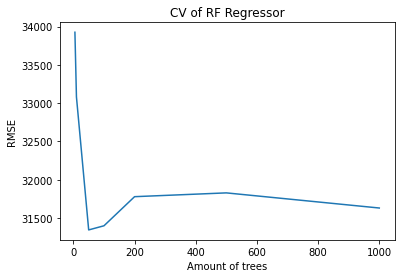

In [ ]:
plt.figure(figsize=(25, 6)) 
plt.plot(n_trees,mean_RMSEs)
plt.xlabel('Amount of trees')
plt.ylabel('RMSE')
plt.title('CV of RF Regressor')

 Best Random forest is with maximum trees of 50 with RMSE 31 574.11. 

Submitting the best random forest regressor to Kaggle. 

In [ ]:
rf = RandomForestRegressor(n_estimators=50)
rf.fit(train_mix_all, np.array(y_all))

test_y_predictions_rf = rf.predict(test_mix_all)

submission_rf_pca2 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_rf},
    columns = ['Id', 'SalePrice'])
submission_rf_pca2.to_csv('submission_rf_pca2.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_rf_pca2.csv -m "RF + PCA2 Submission"  # rmsle=0.16825

100% 20.6k/20.6k [00:01<00:00, 18.9kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

In [ ]:
#for final results
rf = RandomForestRegressor(n_estimators=200)
rf.fit(train_X_mix_all, train_y)
rf_rmse=np.round(mean_squared_error(val_y, rf.predict(val_X_mix_all), squared=False),3)
rf_rmsle=np.round(mean_squared_log_error(val_y, rf.predict(val_X_mix_all), squared=False),3)
print(f'The RMSE for Decision Tree Regressor with PCA is {rf_rmse} and the RMSLE is {rf_rmsle}')

The RMSE for Decision Tree Regressor with PCA is 30780.773 and the RMSLE is 0.123


### 9.2.5 Bagging

In [ ]:
n_estimators = [100,200,400,600,800] 

for i, n_estimator in enumerate(n_estimators):
  model_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=n_estimator)

  n_folds = 4
  br_fold_RMSEs = np.zeros(n_folds)

  X=np.array(train_mix_all)
  y=np.ravel(y_all)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # train all three models
    model_br.fit(X_train, y_train)

    val_predictions_br = model_br.predict(X_val)

    br_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_br, squared = False)

    fold_indx += 1

  print(f'Bagging : average validation RMSE with n_estimators = {n_estimator} is {np.mean(br_fold_RMSEs)}')

Bagging : average validation RMSE with n_estimators = 100 is 31964.3372911756
Bagging : average validation RMSE with n_estimators = 200 is 31621.05297849082
Bagging : average validation RMSE with n_estimators = 400 is 31921.83038744938
Bagging : average validation RMSE with n_estimators = 600 is 31643.74092701592
Bagging : average validation RMSE with n_estimators = 800 is 31577.95111507499


Bagging with n_estimators=800 gives the best result.

In [ ]:
m_br2 = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=800)
m_br2.fit(train_X_mix_all, train_y)
val_pred_br_pca2=m_br2.predict(val_X_mix_all)
br_rmse3=np.round(mean_squared_error(val_y, val_pred_br_pca2, squared=False),3)
br_rmsle3=np.round(mean_squared_log_error(val_y, val_pred_br_pca2, squared=False),3)

print(f'The RMSE for Bagging with n_estimators=800 is {br_rmse3} and the RMSLE is {br_rmsle3}')

The RMSE for Bagging with n_estimators=800 is 28452.765 and the RMSLE is 0.12


In [ ]:
m_br = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=800)
m_br.fit(train_mix_all, np.ravel(np.array(train_df2[['SalePrice']])))

test_y_predictions_br3 = m_gbr.predict(test_mix_all)

submission_br3 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_br3},
    columns = ['Id', 'SalePrice'])
submission_br3.to_csv('submission_br3.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_br3.csv -m "Bagging PCA3 submission"

100% 33.6k/33.6k [00:01<00:00, 18.3kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.15224

### 9.2.6 Gradient Boosting

In [ ]:
n_estimators = [100,200,300,400,500,600,700] 

val_fold_gbr = np.zeros(len(n_estimators))

for i, n_estimator in enumerate(n_estimators):
  model_gbr = GradientBoostingRegressor(random_state=111, n_estimators=n_estimator)

  n_folds = 4
  gbr_fold_RMSEs = np.zeros(n_folds)

  X=np.array(train_mix_all)
  y=np.ravel(y_all)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle =True, random_state=111) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1

  # folds.split is an iterator that loops over different folds
  # returning a tuple with train and val indeces
  for train_index, val_index in folds.split(X, y):
    #print(f"CV #{fold_indx}")
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


    model_gbr.fit(X_train, y_train)

    val_predictions_gbr = model_gbr.predict(X_val)

    gbr_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions_gbr, squared = False)

    fold_indx += 1

  print(f'Gradient Boosting with n_estimator = {n_estimator} : average validation RMSE is {np.mean(gbr_fold_RMSEs)}')
  val_fold_gbr = np.zeros(len(n_estimators))

Gradient Boosting with n_estimator = 100 : average validation RMSE is 29127.56425488973
Gradient Boosting with n_estimator = 200 : average validation RMSE is 28687.326754305548
Gradient Boosting with n_estimator = 300 : average validation RMSE is 28628.15983650076
Gradient Boosting with n_estimator = 400 : average validation RMSE is 28721.312766569157
Gradient Boosting with n_estimator = 500 : average validation RMSE is 28790.362478651496
Gradient Boosting with n_estimator = 600 : average validation RMSE is 28824.949001580724
Gradient Boosting with n_estimator = 700 : average validation RMSE is 28801.259148259705


Gradient Boosting gives the best result with n_estimators 300.

In [ ]:
m_gbr2 = GradientBoostingRegressor(n_estimators=300)
m_gbr2.fit(train_X_mix_all, train_y)
val_pred_gbr_pca2=m_gbr2.predict(val_X_mix_all)
gbr_rmse3=np.round(mean_squared_error(val_y, val_pred_gbr_pca2, squared=False),3)
gbr_rmsle3=np.round(mean_squared_log_error(val_y, val_pred_gbr_pca2, squared=False),3)

print(f'The RMSE for GradientBoosting with n_estimators=400 is {gbr_rmse3} and the RMSLE is {gbr_rmsle3}')

The RMSE for GradientBoosting with n_estimators=400 is 26481.761 and the RMSLE is 0.121


In [ ]:
m_gbr = GradientBoostingRegressor(n_estimators=300)
m_gbr.fit(train_mix_all, np.array(train_df2[['SalePrice']]))

test_y_predictions_gbr3 = m_gbr.predict(test_mix_all)

submission_gbr3 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_gbr3},
    columns = ['Id', 'SalePrice'])
submission_gbr3.to_csv('submission_gbr3.csv', index = False)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_gbr3.csv -m "Gradient Boosting PCA3 submission"

100% 33.6k/33.6k [00:01<00:00, 22.6kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.15224

### 9.2.7 XGBoost

In [ ]:
#https://xgboost.readthedocs.io/en/latest/python/python_api.html

n_estimators = [100,200,300,400,500,600,700] 

for i, n_estimator in enumerate(n_estimators):
  model_xgb = xgb.XGBRegressor(n_estimators=n_estimator,objective='reg:squarederror')

  n_folds = 4
  xg_fold_RMSEs = np.zeros(n_folds)

  X=np.array(train_mix_all)
  y=np.ravel(y_all)

  # initialise splitting mechanism
  folds = KFold(n_splits=n_folds, shuffle = False) 

  # here actual splitting is done
  folds.get_n_splits(X, y)

  fold_indx = 1
  for train_index, val_index in folds.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]


    model_xgb.fit(X_train, y_train)

    val_predictions = model_xgb.predict(X_val)

    xg_fold_RMSEs[fold_indx-1] = mean_squared_error(y_val, val_predictions, squared = False)

    fold_indx += 1

  print(f'XGBoost with n_estimator = {n_estimator} : average validation RMSE is {np.mean(xg_fold_RMSEs)}')

XGBoost with n_estimator = 100 : average validation RMSE is 27710.16017721862
XGBoost with n_estimator = 200 : average validation RMSE is 27108.128376131863
XGBoost with n_estimator = 300 : average validation RMSE is 27023.47054815729
XGBoost with n_estimator = 400 : average validation RMSE is 27019.490466199728
XGBoost with n_estimator = 500 : average validation RMSE is 26986.85209644699
XGBoost with n_estimator = 600 : average validation RMSE is 27025.31249249352
XGBoost with n_estimator = 700 : average validation RMSE is 27031.157903479434



XGBoost with n_estimators=500 is the best.

In [ ]:
m_xgb2 = xgb.XGBRegressor(n_estimators=500, objective= 'reg:squarederror')
m_xgb2.fit(train_X_mix_all, train_y)
val_pred_xgb_pca2=m_xgb2.predict(val_X_mix_all)

xgb_rmse3=np.round(mean_squared_error(val_y, val_pred_xgb_pca2, squared=False),3)
xgb_rmsle3=np.round(mean_squared_log_error(val_y, val_pred_xgb_pca2, squared=False),3)
print(f'The RMSE for XGBoost with n_estimators=500 is {xgb_rmse3} and the RMSLE is {xgb_rmsle3}')

The RMSE for XGBoost with n_estimators=500 is 26376.933 and the RMSLE is 0.117


In [ ]:
m_xgb = xgb.XGBRegressor(n_estimators=500, objective= 'reg:squarederror')
m_xgb.fit(train_mix_all, y_all)

test_y_predictions_xgb3 = m_xgb.predict(test_mix_all)

submission_xgb3 = pd.DataFrame(
    {'Id': test.Id, 'SalePrice': test_y_predictions_xgb3},
    columns = ['Id', 'SalePrice'])
submission_xgb3.to_csv('submission_xgb3.csv', index = False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission_xgb3.csv -m "XGBoost Submission PCA3"

100% 21.1k/21.1k [00:02<00:00, 10.2kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Kaggle score: 0.14971

# Conclusion 

We tried different models on three different datasets and submitted the results to Kaggle.

The methods used were Regressions (Linear, Lasso, Ridge), Decision Tree and Random Forest, Ensembling (Linear Regression, Lasso, Ridge and Decision Tree), Boosting and Bagging (Adaptive Boosting, Bagging, Gradient Boosting and XGBoost).

We then used PCA for dimensionality reduction (only on numerical variables) and used the methods on this dataset.

Finaly we added categorical variables as dummy variables to the PCA dataset and used the methods once more.

Based on the RMSE of the models, the best results had models which were run on the regular data set with dummy variables (ensemble and Gradient Boosting). **Actually the best RMSE is with second PCA dataset and XGBoost?**

We also submitted our models to the Kaggle competition and got 1786. place with the Gradient Boositing model which was fitted on the regular dataset (without PCA).



# References 

[1] https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv 

[2] https://medium.com/@vaibhavshukla182/how-to-solve-mismatch-in-train-and-test-set-after-categorical-encoding-8320ed03552f